In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

from keras.models import Model
from keras import optimizers
from keras.models import Sequential
from keras.layers import LSTM, Input, Embedding, Lambda, Dense, concatenate, Flatten, Dropout
from keras.layers.normalization import BatchNormalization
import keras.backend as K
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import StratifiedKFold, KFold,cross_val_score
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import mean_squared_error
from math import sqrt
from xgboost import XGBRegressor
import lightgbm as lgb

import datetime
from time import time
import gc

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from gensim.models import KeyedVectors
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

import xgboost as xgb
import lightgbm as lgb

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['gnewsvector', 'y-test', 'home-depot-product-search-relevance']


# Read the data

In [2]:
train = pd.read_csv('../input/home-depot-product-search-relevance/train.csv', encoding="ISO-8859-1")
test = pd.read_csv('../input/home-depot-product-search-relevance/test.csv', encoding="ISO-8859-1")
prod_att = pd.read_csv('../input/home-depot-product-search-relevance/attributes.csv', encoding="ISO-8859-1")
y_test = pd.read_csv('../input/y-test/solution.csv', encoding="ISO-8859-1")

print('train size', train.shape)
print('test size', test.shape)
print('prod_att size', prod_att.shape)
print('y_test size', y_test.shape)

train size (74067, 5)
test size (166693, 4)
prod_att size (2044803, 3)
y_test size (166693, 3)


# Add test relevence to calculate test MAE

In [3]:
# THIS CELL ADDED ONLY IN THE END AFTER WE GET FINAL MODEL (ON TRAIN SET) 

test = pd.merge(test, y_test, on='id', how='left')
test = test.loc[test['Usage'] != 'Ignored']
test.drop(['Usage'], axis=1, inplace=True)

In [4]:
train_size = train.shape[0]
df_all = pd.concat((train, test), axis=0, ignore_index=True)

In [5]:
df_all.head()

,id,product_uid,product_title,search_term,relevance
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67


In [6]:
prod_att_metrial = prod_att.loc[prod_att['name'] == 'Material'][['product_uid', 'value']].drop_duplicates(['product_uid'])
prod_att_brand = prod_att.loc[prod_att['name'] == 'MFG Brand Name'][['product_uid', 'value']].drop_duplicates(['product_uid'])

def merge_att(att_df):
    global df_all
    df_all = pd.merge(df_all, att_df, on='product_uid', how='left')
    df_all = df_all.fillna('')
    df_all['product_title'] = df_all['product_title'] + ' ' + df_all['value']
    df_all.drop(['value'], axis=1, inplace=True)
    return df_all

df_all = merge_att(prod_att_metrial)
df_all = merge_att(prod_att_brand)

In [7]:
df_all.head()

,id,product_uid,product_title,search_term,relevance
0,2,100001,Simpson Strong-Tie 12-Gauge Angle Galvanized S...,angle bracket,3.00
1,3,100001,Simpson Strong-Tie 12-Gauge Angle Galvanized S...,l bracket,2.50
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67


# Difine labels

In [8]:
y_data = train['relevance']

# transform relevance to labels
le_labels = LabelEncoder()
le_labels.fit(y_data.unique())
y_data_labels = le_labels.transform(y_data)

# Check max product description and search term length to know how much padding needed

In [9]:
def get_max_length(data):
    max_len = 0
    for i in range(0, len(data)):
        n_words = len(data.iloc[i].split())
        if n_words > max_len:
            max_len = n_words
    return max_len

max_length_prod = get_max_length(df_all['product_title'])
max_length_search = get_max_length(df_all['search_term'])

print('max_length_prod', max_length_prod)
print('max_length_search', max_length_search)

max_length_prod 59
max_length_search 14


# Word embedding

In [10]:
embed_size = 300
max_features = 50000 

# Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features, filters='!"$&()*+,-.:;<=>?[\]^_`{|}~')
tokenizer.fit_on_texts(list(df_all['product_title'].append(df_all['search_term']).values))

X_train_prod = tokenizer.texts_to_sequences(train['product_title'].values)
X_train_search = tokenizer.texts_to_sequences(train['search_term'].values)
X_test_prod = tokenizer.texts_to_sequences(test['product_title'].values)
X_test_search = tokenizer.texts_to_sequences(test['search_term'].values)

# Padding by the max_length_prod and max_length_search

In [11]:
max_length = max(max_length_prod, max_length_search)

X_train_prod = pad_sequences(X_train_prod, maxlen=max_length)
X_train_search = pad_sequences(X_train_search, maxlen=max_length)
X_test_prod = pad_sequences(X_test_prod, maxlen=max_length)
X_test_search = pad_sequences(X_test_search, maxlen=max_length)

# Assign embedding to words by GoogleNews-vectors-negative300 embedding 

In [12]:
EMBEDDING_FILE = '../input/gnewsvector/GoogleNews-vectors-negative300.bin'
embeddings_index = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index)) + 1
embedding_matrix = (np.random.rand(nb_words, embed_size) - 0.5) / 5.0
embedding_matrix[0] = 0
for word, i in word_index.items():
    if i >= max_features: 
        continue
    if word in embeddings_index:
        embedding_matrix[i] = embeddings_index.get_vector(word)

In [13]:
del embeddings_index
del train
del prod_att
del df_all
gc.collect()

7

# Normalized the labels

In [14]:
min_val = y_data.min()
max_val = y_data.max()
y_data_norm = (y_data - min_val) / (max_val - min_val)

# Build the model

In [15]:
# Model variables
n_lstm_hidden = 25
batch_size = 256
n_epoch = 5

def get_model():

    # input layer
    left_input = Input(shape=(max_length, ))
    right_input = Input(shape=(max_length, ))
    
    # embedding layers
    embedding_layer = Embedding(nb_words, output_dim=embed_size, input_length=max_length, weights=[embedding_matrix])

    # Embedded version of the inputs
    encoded_left = embedding_layer(left_input)
    encoded_right = embedding_layer(right_input)

    # LSTM layer
    shared_lstm = LSTM(n_lstm_hidden)
    left_output = shared_lstm(encoded_left)
    right_output = shared_lstm(encoded_right)
    
    # batch normalization layer
    left_output = BatchNormalization()(left_output)
    right_output = BatchNormalization()(right_output)

    # concat two outputs
    concat = concatenate([left_output, right_output])
    
    dense_1 = Dense(50, activation="relu")(concat)
    dropout_1 = Dropout(0.5)(dense_1)

    # add Dense layer to calculate the similarty between product title and search term
    output = Dense(1, activation="relu")(dropout_1)

    # Pack it all up into a model
    siamese_model = Model([left_input, right_input], output)

    # colmpiling
    siamese_model.compile(loss='mse', optimizer='adam')
    return siamese_model

In [16]:
def split_to_train_val(data_x, train_index, val_index):
    X_train = data_x[train_index]
    X_val = data_x[val_index]
    
    return X_train, X_val

In [17]:
# Plot loss
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

In [18]:
def plot_fiting(y_pred, y_true):
    n_samples = 100
    axis=[x for x in range(n_samples)]
    plt.plot(axis, y_true[:n_samples], marker='.', label="actual")
    plt.plot(axis, y_pred[:n_samples], 'r', label="prediction")
    plt.ylabel('Relevance', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show()

In [19]:
mean_mae_train = 0
mean_rmse_train = 0
mean_mae_val = 0
mean_rmse_val = 0

def eval(y_true, y_pred, is_val=True):
    global mean_mae_train, mean_rmse_train, mean_mae_val, mean_rmse_val
    
    y_true_norm = (y_true * (max_val - min_val)) + min_val
    y_pred_norm = (y_pred * (max_val - min_val)) + min_val
    
    mae_value = mean_absolute_error(y_true_norm, y_pred_norm)
    rmse_value = sqrt(mean_squared_error(y_true_norm, y_pred_norm))
    
    if is_val:
        mean_mae_val += (mae_value / n_splits)
        mean_rmse_val += (rmse_value / n_splits)
    else:
        mean_mae_train += (mae_value / n_splits)
        mean_rmse_train += (rmse_value / n_splits)
        
    print('mae_value', mae_value)
    print('rmse_value', rmse_value)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Train on 59251 samples, validate on 14816 samples
Epoch 1/5
59251/59251 [==============================] - 124s 2ms/step - loss: 0.2514 - val_loss: 0.0719
Epoch 2/5
59251/59251 [==============================] - 120s 2ms/step - loss: 0.0804 - val_loss: 0.0642
Epoch 3/5
59251/59251 [==============================] - 120s 2ms/step - loss: 0.0648 - val_loss: 0.0616
Epoch 4/5
59251/59251 [==============================] - 120s 2ms/step - loss: 0.0583 - val_loss: 0.0595
Epoch 5/5
59251/59251 [==============================] - 120s 2ms/step - loss: 0.0535 - val_loss: 0.0597
mae_value 0.3335956692461025
rmse_value 0.42375617592623593
mae_value 0.38849238618983045
rmse_value 0.4888162869236834


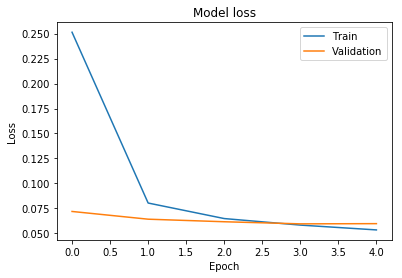

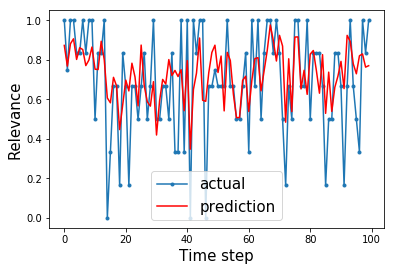

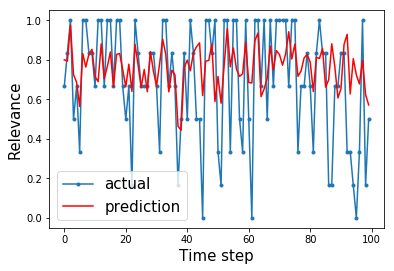

Train on 59253 samples, validate on 14814 samples
Epoch 1/5
59253/59253 [==============================] - 126s 2ms/step - loss: 0.3099 - val_loss: 0.0743
Epoch 2/5
59253/59253 [==============================] - 123s 2ms/step - loss: 0.0881 - val_loss: 0.0646
Epoch 3/5
59253/59253 [==============================] - 122s 2ms/step - loss: 0.0670 - val_loss: 0.0619
Epoch 4/5
59253/59253 [==============================] - 124s 2ms/step - loss: 0.0601 - val_loss: 0.0599
Epoch 5/5
59253/59253 [==============================] - 123s 2ms/step - loss: 0.0555 - val_loss: 0.0584
mae_value 0.34465876464600076
rmse_value 0.42879501130834946
mae_value 0.3909282833393309
rmse_value 0.4835053266003088


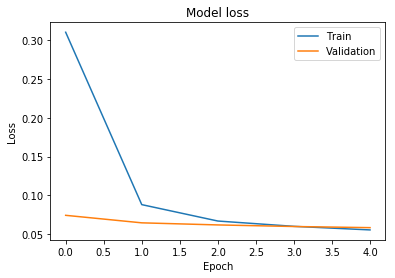

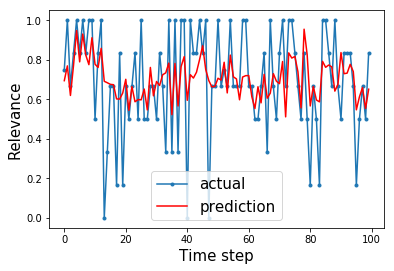

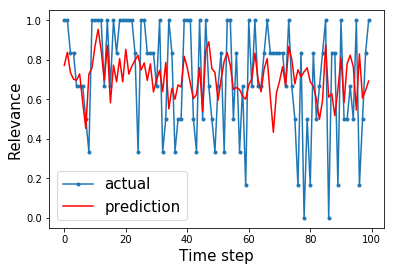

Train on 59254 samples, validate on 14813 samples
Epoch 1/5
59254/59254 [==============================] - 127s 2ms/step - loss: 0.2838 - val_loss: 0.0724
Epoch 2/5
59254/59254 [==============================] - 124s 2ms/step - loss: 0.0833 - val_loss: 0.0639
Epoch 3/5
59254/59254 [==============================] - 124s 2ms/step - loss: 0.0655 - val_loss: 0.0611
Epoch 4/5
59254/59254 [==============================] - 123s 2ms/step - loss: 0.0583 - val_loss: 0.0590
Epoch 5/5
59254/59254 [==============================] - 124s 2ms/step - loss: 0.0539 - val_loss: 0.0581
mae_value 0.3445195038407879
rmse_value 0.42426953361145464
mae_value 0.39310658922815417
rmse_value 0.4819021902588037


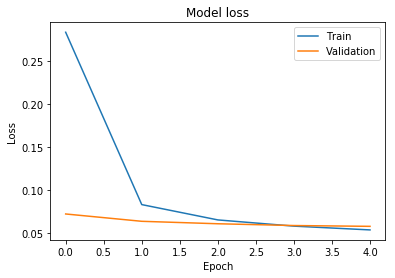

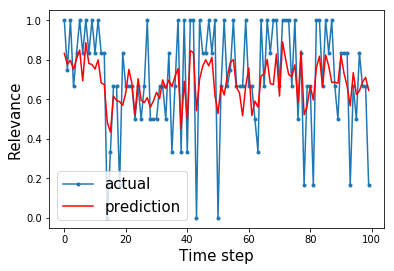

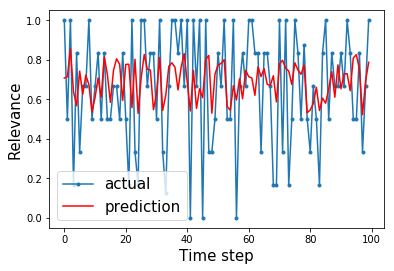

Train on 59254 samples, validate on 14813 samples
Epoch 1/5
59254/59254 [==============================] - 128s 2ms/step - loss: 0.2479 - val_loss: 0.0725
Epoch 2/5
59254/59254 [==============================] - 124s 2ms/step - loss: 0.0816 - val_loss: 0.0631
Epoch 3/5
59254/59254 [==============================] - 124s 2ms/step - loss: 0.0653 - val_loss: 0.0605
Epoch 4/5
59254/59254 [==============================] - 125s 2ms/step - loss: 0.0586 - val_loss: 0.0586
Epoch 5/5
59254/59254 [==============================] - 124s 2ms/step - loss: 0.0541 - val_loss: 0.0576
mae_value 0.34061543375182257
rmse_value 0.4221192055795351
mae_value 0.38977417748148063
rmse_value 0.4798857318928503


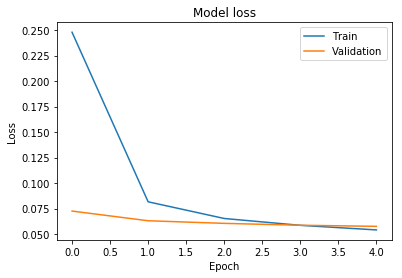

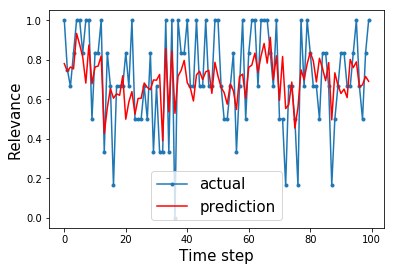

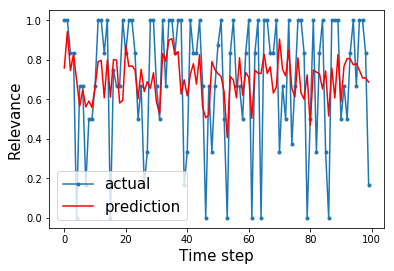

Train on 59256 samples, validate on 14811 samples
Epoch 1/5
59256/59256 [==============================] - 128s 2ms/step - loss: 0.2388 - val_loss: 0.0702
Epoch 2/5
59256/59256 [==============================] - 122s 2ms/step - loss: 0.0786 - val_loss: 0.0634
Epoch 3/5
59256/59256 [==============================] - 121s 2ms/step - loss: 0.0640 - val_loss: 0.0601
Epoch 4/5
59256/59256 [==============================] - 120s 2ms/step - loss: 0.0576 - val_loss: 0.0587
Epoch 5/5
59256/59256 [==============================] - 120s 2ms/step - loss: 0.0535 - val_loss: 0.0578
mae_value 0.33418572031077187
rmse_value 0.41904642175507484
mae_value 0.3880188696875883
rmse_value 0.4808441028028669


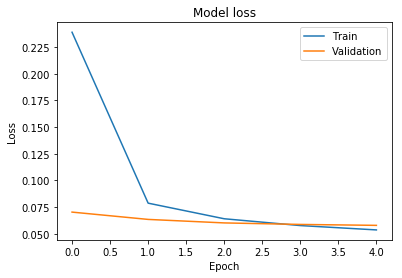

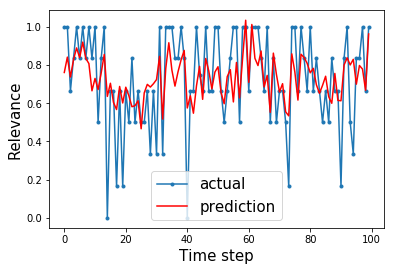

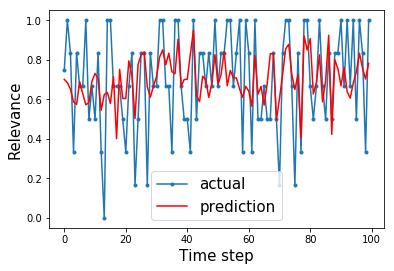

mean_mae_train 0.33951501835909714
mean_rmse_train 0.42359726963613
mean_mae_val 0.3900640611852769
mean_rmse_val 0.4829907276957026
end time 3738.241
mean train time 619.531
mean pred time 76.5026


In [20]:
pred_test = np.zeros(X_test_prod.shape[0])

n_splits = 5
# kfold = KFold(n_splits=n_splits, shuffle=True, random_state=24)
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=24)

mean_train_time = 0
mean_pred_time = 0
start_time = time()

for train_index, val_index in kfold.split(X_train_prod, y_data_labels):
    y_train_kfold = y_data_norm[train_index] 
    y_val_kfold = y_data_norm[val_index]
    X_train_left_kfold, X_val_left_kfold = split_to_train_val(X_train_prod, train_index, val_index)
    X_train_right_kfold, X_val_right_kfold = split_to_train_val(X_train_search, train_index, val_index)
    
    start = time()
    siamese_model = get_model()
    history = siamese_model.fit([X_train_left_kfold, X_train_right_kfold], y_train_kfold,
                            batch_size=batch_size, epochs=n_epoch,
                            validation_data=([X_val_left_kfold, X_val_right_kfold], y_val_kfold))
    mean_train_time += (round(time()-start, 3) / n_splits)
    
    pred_train = siamese_model.predict([X_train_left_kfold, X_train_right_kfold])
    pred_val = siamese_model.predict([X_val_left_kfold, X_val_right_kfold])
    eval(y_train_kfold, pred_train, False)
    eval(y_val_kfold, pred_val, True)
    
    start = time()
    pred_test += np.reshape((siamese_model.predict([X_test_prod, X_test_search]) / n_splits), (len(pred_test),))
    mean_pred_time += (round(time()-start, 3) / n_splits)
    
    plot_loss(history)
    plot_fiting(pred_train, y_train_kfold)
    plot_fiting(pred_val, y_val_kfold)
    
print('mean_mae_train', mean_mae_train)
print('mean_rmse_train', mean_rmse_train)
print('mean_mae_val', mean_mae_val)
print('mean_rmse_val', mean_rmse_val)
print('end time', round(time()-start_time, 3))
print('mean train time', mean_train_time)
print('mean pred time', mean_pred_time)

# Use the model we got as feature extractor 
1. for XGBoost model
2. for lightgbm model

In [21]:
# split to train and validation sets
train_indx = int(0.8*X_train_prod.shape[0])
X_train_left = X_train_prod[:train_indx]
X_val_left = X_train_prod[train_indx:]
X_train_right = X_train_search[:train_indx]
X_val_right =X_train_search[train_indx:]
y_train = y_data_norm[:train_indx]
y_val = y_data_norm[train_indx:]

print('X_train_left shape', X_train_left.shape)
print('X_val_left shape', X_val_left.shape)
print('X_train_right shape', X_train_right.shape)
print('X_val_right shape', X_val_right.shape)
print('y_train shape', y_train.shape)
print('y_val shape', y_val.shape)

X_train_left shape (59253, 59)
X_val_left shape (14814, 59)
X_train_right shape (59253, 59)
X_val_right shape (14814, 59)
y_train shape (59253,)
y_val shape (14814,)


In [22]:
# Train the model on train and then predict train, val and test to get features
siamese_model = get_model()
history = siamese_model.fit([X_train_left, X_train_right], y_train.values, batch_size=batch_size, epochs=n_epoch)

# get the output of the concat layer and use it as features to the ml models
concat_layer = siamese_model.layers[6].output
feature_model = Model(siamese_model.input, concat_layer)
feature_model.compile(loss='mse', optimizer='adam')
print(feature_model.summary())

# we use the output of the concat layer as fetures so they will be the input to the xgb and lgb models
featurs = feature_model.predict([X_train_left, X_train_right])

# we preform the prediction also on the test set to evaluate rmse and mae on val set
features_val = feature_model.predict([X_val_left, X_val_right])

# we preform the prediction also on the test set to evaluate the mse on test set
features_test = feature_model.predict([X_test_prod, X_test_search])

Epoch 1/5
59253/59253 [==============================] - 120s 2ms/step - loss: 0.2520
Epoch 2/5
59253/59253 [==============================] - 116s 2ms/step - loss: 0.0813
Epoch 3/5
59253/59253 [==============================] - 116s 2ms/step - loss: 0.0648
Epoch 4/5
59253/59253 [==============================] - 116s 2ms/step - loss: 0.0581
Epoch 5/5
59253/59253 [==============================] - 116s 2ms/step - loss: 0.0537
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 59)           0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 59)           0                                            
___________________________________________________________________________

In [32]:
y_train = (y_train - min_val) / (max_val - min_val)
y_val = (y_val - min_val) / (max_val - min_val)

In [33]:
# xgb
start1 = time()
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.008, gamma=0, subsample=0.6, colsample_bytree=1, max_depth=4)
xgb_model.fit(featurs, y_train)
print("xgb train time", round(time()-start1, 3))

start2 = time()
xgb_pred_test = xgb_model.predict(features_test)
print("xgb predict time", round(time()-start2, 3))
print("xgb total time", round(time()-start1, 3))
xgb_pred_val = xgb_model.predict(features_val)
xgb_pred_train = xgb_model.predict(featurs)

# lgb
start1 = time()
lgb_model = lgb.sklearn.LGBMRegressor(is_unbalance=True, learning_rate =0.008, subsample=0.8, colsample_bytree=0.6, max_depth=6, num_leaves=72)
lgb_model.fit(featurs, y_train)
print("lgb train time", round(time()-start1, 3))

start2 = time()
lgb_pred_test = lgb_model.predict(features_test)
print("lgb predict time", round(time()-start2, 3))
print("lgb total time", round(time()-start1, 3))
lgb_pred_val = lgb_model.predict(features_val)
lgb_pred_train = lgb_model.predict(featurs)

xgb train time 15.119
xgb predict time 0.45
xgb total time 15.569
lgb train time 2.353
lgb predict time 0.965
lgb total time 3.319


In [38]:
lgb_pred_val_2 = lgb_pred_val
lgb_pred_train_2 = lgb_pred_train
xgb_pred_val_2 = xgb_pred_val
xgb_pred_train_2 = xgb_pred_train

pred_test mae 0.4136978467307811
pred_test rmse 0.5093312988950933
lgb_pred_test mae 0.42680241565492494
lgb_pred_test rmse 0.5228411572059214
lgb_pred_train mae 0.39896969359011347
lgb_pred_train rmse 0.484189189204522
lgb_pred_val mae 0.4150664836094004
lgb_pred_val rmse 0.5214178581670308
xgb_pred_test mae 0.45040197920875635
xgb_pred_test rmse 0.5384978823039926
xgb_pred_train mae 0.43692908342431075
xgb_pred_train rmse 0.518080985227701
xgb_pred_val mae 0.4120327381626127
xgb_pred_val rmse 0.5074254507119854
siamese test


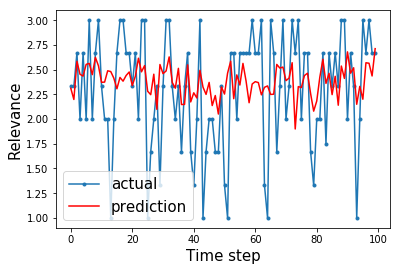

lgb test


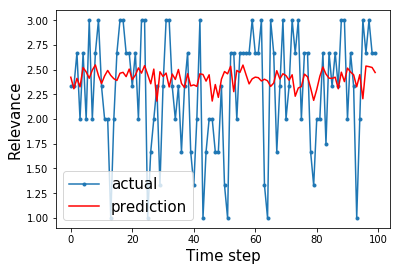

xgb test


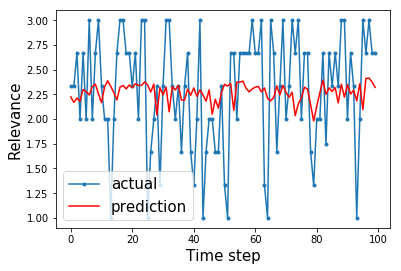

lgb train


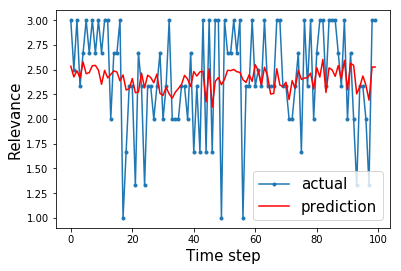

xgb train


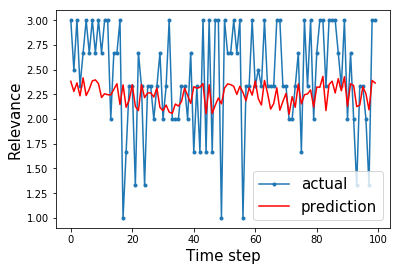

lgb val


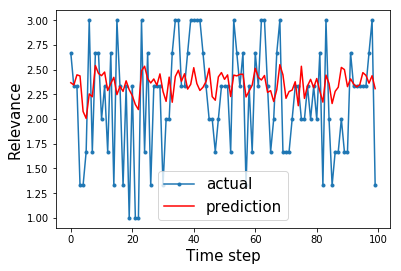

xgb val


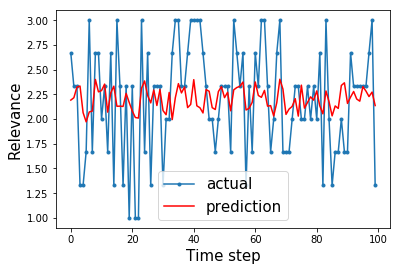

In [53]:
def round_pred(pred):
    pred = (pred * (max_val - min_val)) + min_val
    for i in range(0,len(pred)):
        if pred[i] < 1:
            pred[i] = 1
        if pred[i] > 3:
            pred[i] = 3
    return pred

def eval_festure(y_true, y_pred, title):
    print(title, 'mae', mean_absolute_error(y_true, y_pred))
    print(title, 'rmse', sqrt(mean_squared_error(y_true, y_pred)))

xgb_pred_test = round_pred(xgb_pred_test.astype(float))
lgb_pred_test = round_pred(lgb_pred_test.astype(float))

xgb_pred_train = round_pred(xgb_pred_train.astype(float))
lgb_pred_train = round_pred(lgb_pred_train.astype(float))

xgb_pred_val = round_pred(xgb_pred_val.astype(float))
lgb_pred_val = round_pred(lgb_pred_val.astype(float))

pred_test = (pred_test * (max_val - min_val)) + min_val
y_train = (y_train * (max_val - min_val)) + min_val
y_val = (y_val * (max_val - min_val)) + min_val

eval_festure(test['relevance'], pred_test, 'pred_test')
eval_festure(test['relevance'], lgb_pred_test, 'lgb_pred_test')
eval_festure(y_train, lgb_pred_train, 'lgb_pred_train')
eval_festure(y_val, lgb_pred_val, 'lgb_pred_val')
eval_festure(test['relevance'], xgb_pred_test, 'xgb_pred_test')
eval_festure(y_train, xgb_pred_train, 'xgb_pred_train')
eval_festure(y_val, xgb_pred_val, 'xgb_pred_val')

print('siamese test')
plot_fiting(pred_test, test['relevance'])
print('lgb test')
plot_fiting(lgb_pred_test, test['relevance'])
print('xgb test')
plot_fiting(xgb_pred_test, test['relevance'])

print('lgb train')
plot_fiting(lgb_pred_train, y_train)
print('xgb train')
plot_fiting(xgb_pred_train, y_train)

print('lgb val')
plot_fiting(lgb_pred_val, y_val)
print('xgb val')
plot_fiting(xgb_pred_val, y_val)

# Write predictions to sample submission file

In [ ]:
sample_sub = pd.DataFrame()
sample_sub['id'] = test['id']
sample_sub['relevance'] = pred_test
sample_sub.to_csv('sample_submmision_word_siamese.csv', index=False)